# STUMPY Basics

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/TDAmeritrade/stumpy/main?filepath=notebooks/Tutorial_STUMPY_Basics.ipynb)

## Analyzing Motifs and Anomalies with STUMP

This tutorial utilizes the main takeaways from the research papers: [Matrix Profile I](http://www.cs.ucr.edu/~eamonn/PID4481997_extend_Matrix%20Profile_I.pdf) & [Matrix Profile II](http://www.cs.ucr.edu/~eamonn/STOMP_GPU_final_submission_camera_ready.pdf).

To explore the basic concepts, we'll use the workhorse `stump` function to find interesting motifs (patterns) or discords (anomalies/novelties) and demonstrate these concepts with two different time series datasets: 

1. The Steamgen dataset
2. The NYC taxi passengers dataset

`stump` is Numba JIT-compiled version of the popular STOMP algorithm that is described in detail in the original [Matrix Profile II](http://www.cs.ucr.edu/~eamonn/STOMP_GPU_final_submission_camera_ready.pdf) paper. `stump` is capable of parallel computation and it performs an ordered search for patterns and outliers within a specified time series and takes advantage of the locality of some calculations to minimize the runtime.

## Getting Started

Let's import the packages that we'll need to load, analyze, and plot the data.

In [1]:
%matplotlib inline

import pandas as pd
import stumpy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.patches import Rectangle
import datetime as dt

plt.style.use('https://raw.githubusercontent.com/TDAmeritrade/stumpy/main/docs/stumpy.mplstyle')

## What is a Motif?

Time series motifs are approximately repeated subsequences found within a longer time series. Being able to say that a subsequence is "approximately repeated" requires that you be able to compare subsequences to each other. In the case of STUMPY, all subsequences within a time series can be compared by computing the pairwise z-normalized Euclidean distances and then storing only the index to its nearest neighbor. This nearest neighbor distance vector is referred to as the `matrix profile` and the index to each nearest neighbor within the time series is referred to as the `matrix profile index`. Luckily, the `stump` function takes in any time series (with floating point values) and computes the matrix profile along with the matrix profile indices and, in turn, one can immediately find time series motifs. Let's look at an example:

## Loading the Steamgen Dataset

This data was generated using fuzzy models applied to mimic a steam generator at the Abbott Power Plant in Champaign, IL. The data feature that we are interested in is the output steam flow telemetry that has units of kg/s and the data is "sampled" every three seconds with a total of 9,600 datapoints. 

In [2]:
steam_df = pd.read_csv("https://zenodo.org/record/4273921/files/STUMPY_Basics_steamgen.csv?download=1")
steam_df.head()

,drum pressure,excess oxygen,water level,steam flow
0,320.08239,2.506774,0.032701,9.302970
1,321.71099,2.545908,0.284799,9.662621
2,320.91331,2.360562,0.203652,10.990955
3,325.00252,0.027054,0.326187,12.430107
4,326.65276,0.285649,0.753776,13.681666


## Visualizing the Steamgen Dataset

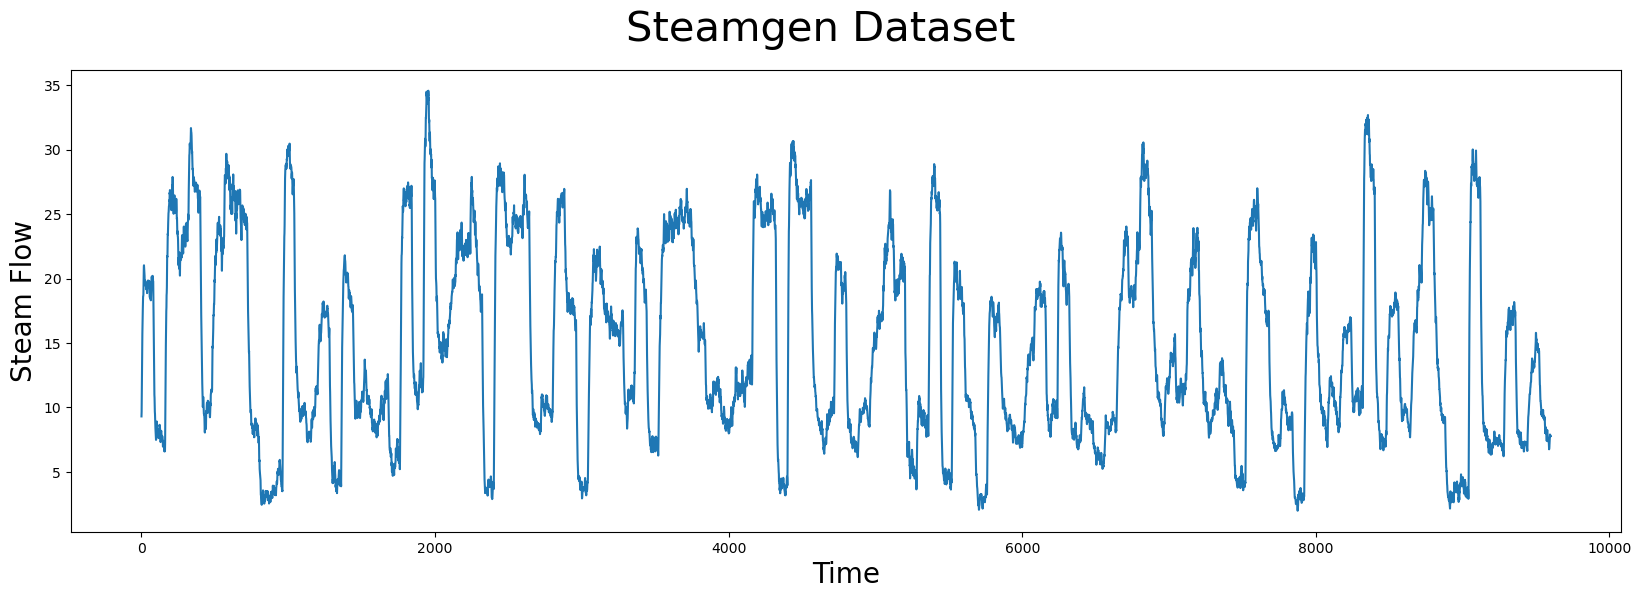

In [3]:
plt.suptitle('Steamgen Dataset', fontsize='30')
plt.xlabel('Time', fontsize ='20')
plt.ylabel('Steam Flow', fontsize='20')
plt.plot(steam_df['steam flow'].values)
plt.show()

Take a moment and carefully examine the plot above with your naked eye. If you were told that there was a pattern that was approximately repeated, can you spot it? Even for a computer, this can be very challenging. Here's what you should be looking for:

## Manually Finding a Motif

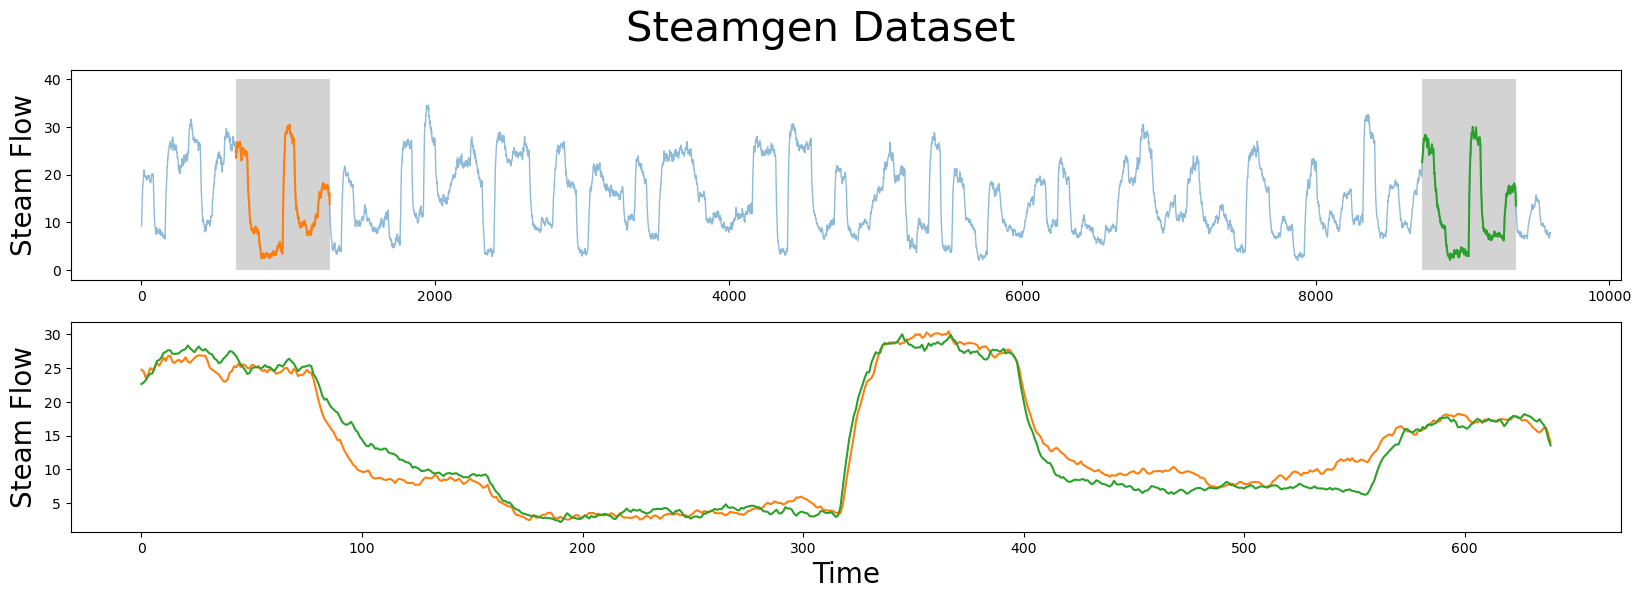

In [4]:
m = 640
fig, axs = plt.subplots(2)
plt.suptitle('Steamgen Dataset', fontsize='30')
axs[0].set_ylabel("Steam Flow", fontsize='20')
axs[0].plot(steam_df['steam flow'], alpha=0.5, linewidth=1)
axs[0].plot(steam_df['steam flow'].iloc[643:643+m])
axs[0].plot(steam_df['steam flow'].iloc[8724:8724+m])
rect = Rectangle((643, 0), m, 40, facecolor='lightgrey')
axs[0].add_patch(rect)
rect = Rectangle((8724, 0), m, 40, facecolor='lightgrey')
axs[0].add_patch(rect)
axs[1].set_xlabel("Time", fontsize='20')
axs[1].set_ylabel("Steam Flow", fontsize='20')
axs[1].plot(steam_df['steam flow'].values[643:643+m], color='C1')
axs[1].plot(steam_df['steam flow'].values[8724:8724+m], color='C2')
plt.show()

The motif (pattern) that we are looking for is highlighted above and yet it is still very hard to be certain that the orange and green subsequences are a match (upper panel), that is, until we zoom in on them and overlay the subsequences on top each other (lower panel). Now, we can clearly see that the motif is very similar! The fundamental value of computing the matrix profile is that it not only allows you to quickly find motifs but it also identifies the nearest neighbor for all subsequences within your time series. Note that we haven't actually done anything special here to locate the motif except that we grab the locations from the original paper and plotted them. Now, let's take our steamgen data and apply the `stump` function to it:

## Find a Motif Using STUMP

In [5]:
m = 640
mp = stumpy.stump(steam_df['steam flow'], m)

`stump` requires two parameters:

1. A time series
2. A window size, `m`

In this case, based on some domain expertise, we've chosen `m = 640`, which is roughly equivalent to half-hour windows. And, again, the output of `stump` is an array that contains all of the matrix profile values (i.e., z-normalized Euclidean distance to your nearest neighbor) and matrix profile indices in the first and second columns, respectively (we'll ignore the third and fourth columns for now). To identify the index location of the motif we'll need to find the index location where the matrix profile, `mp[:, 0]`, has the smallest value:

In [6]:
motif_idx = np.argsort(mp[:, 0])[0]

print(f"The motif is located at index {motif_idx}")

The motif is located at index 643


With this `motif_idx` information, we can also identify the location of its nearest neighbor by cross-referencing the matrix profile indices, `mp[:, 1]`:

In [7]:
nearest_neighbor_idx = mp[motif_idx, 1]

print(f"The nearest neighbor is located at index {nearest_neighbor_idx}")

The nearest neighbor is located at index 8724


Now, let's put all of this together and plot the matrix profile next to our raw data:

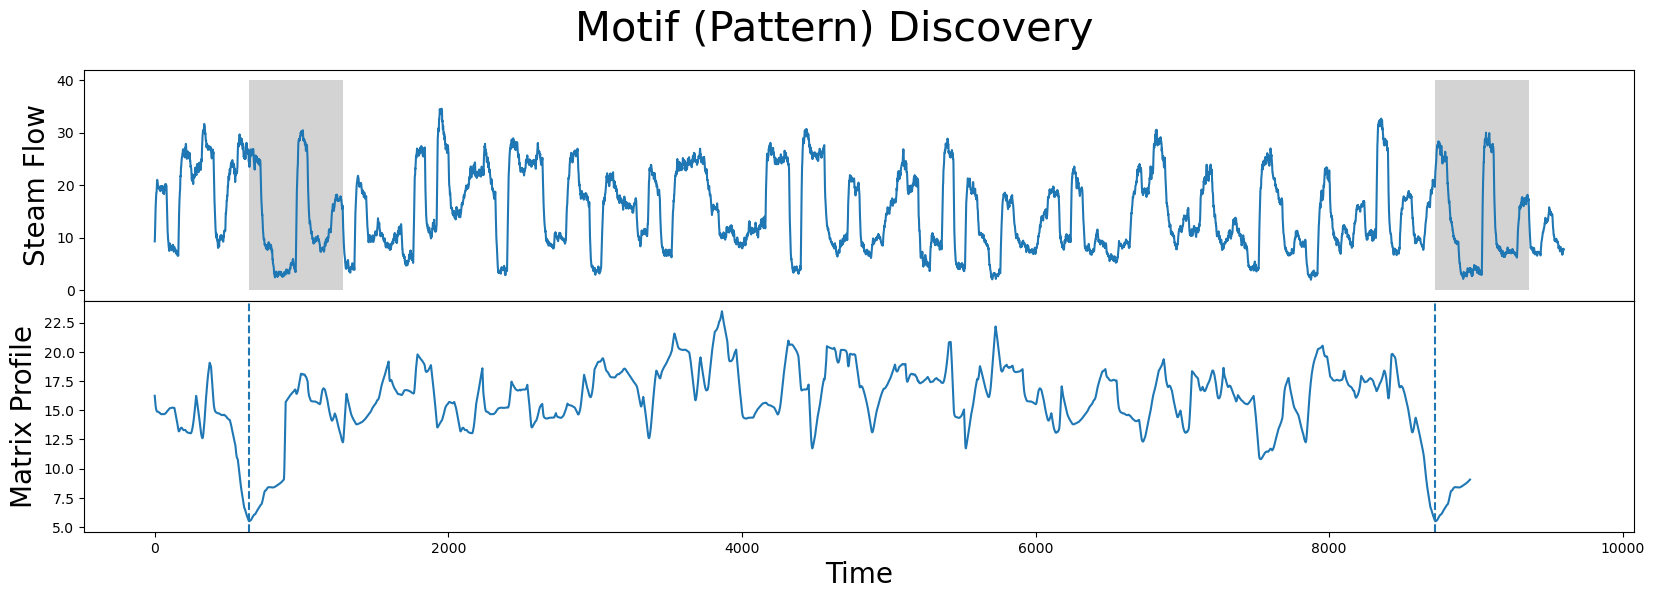

In [8]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
plt.suptitle('Motif (Pattern) Discovery', fontsize='30')

axs[0].plot(steam_df['steam flow'].values)
axs[0].set_ylabel('Steam Flow', fontsize='20')
rect = Rectangle((motif_idx, 0), m, 40, facecolor='lightgrey')
axs[0].add_patch(rect)
rect = Rectangle((nearest_neighbor_idx, 0), m, 40, facecolor='lightgrey')
axs[0].add_patch(rect)
axs[1].set_xlabel('Time', fontsize ='20')
axs[1].set_ylabel('Matrix Profile', fontsize='20')
axs[1].axvline(x=motif_idx, linestyle="dashed")
axs[1].axvline(x=nearest_neighbor_idx, linestyle="dashed")
axs[1].plot(mp[:, 0])
plt.show()

What we learn is that the global minima (vertical dashed lines) from the matrix profile correspond to the locations of the two subsequences that make up the motif pair! And the exact z-normalized Euclidean distance between these two subsequences is: 

In [9]:
mp[motif_idx, 0]

5.4916198277694726

:::{admonition} **Added after STUMPY version 1.12.0**
:class: note

In place of array slicing (i.e., `mp[:, 0]`, `mp[:, 1]`), the matrix profile distances can be accessed directly through the `P_` attribute and the matrix profile indices can be accessed through the `I_` attribute:

```
mp = stumpy.stump(T, m)
print(mp.P_, mp.I_)  # print the matrix profile and the matrix profile indices 
```

Additionally, the left and right matrix profile indices can also be accessed through the `left_I_` and `right_I_` attributes, respectively.
:::

So, this distance isn't zero since we saw that the two subsequences aren't an identical match but, relative to the rest of the matrix profile (i.e., compared to either the mean or median matrix profile values), we can understand that this motif is a significantly good match.   

## Find Potential Anomalies (Discords) using STUMP

Conversely, the index location within our matrix profile that has the largest value (computed from `stump` above) is: 

In [10]:
discord_idx = np.argsort(mp[:, 0])[-1]

print(f"The discord is located at index {discord_idx}")

The discord is located at index 3864


And the nearest neighbor to this discord has a distance that is quite far away:

In [11]:
nearest_neighbor_distance = mp[discord_idx, 0]

print(f"The nearest neighbor subsequence to this discord is {nearest_neighbor_distance} units away")

The nearest neighbor subsequence to this discord is 23.476168367302023 units away


The subsequence located at this global maximum is also referred to as a discord, novelty, or "potential anomaly":

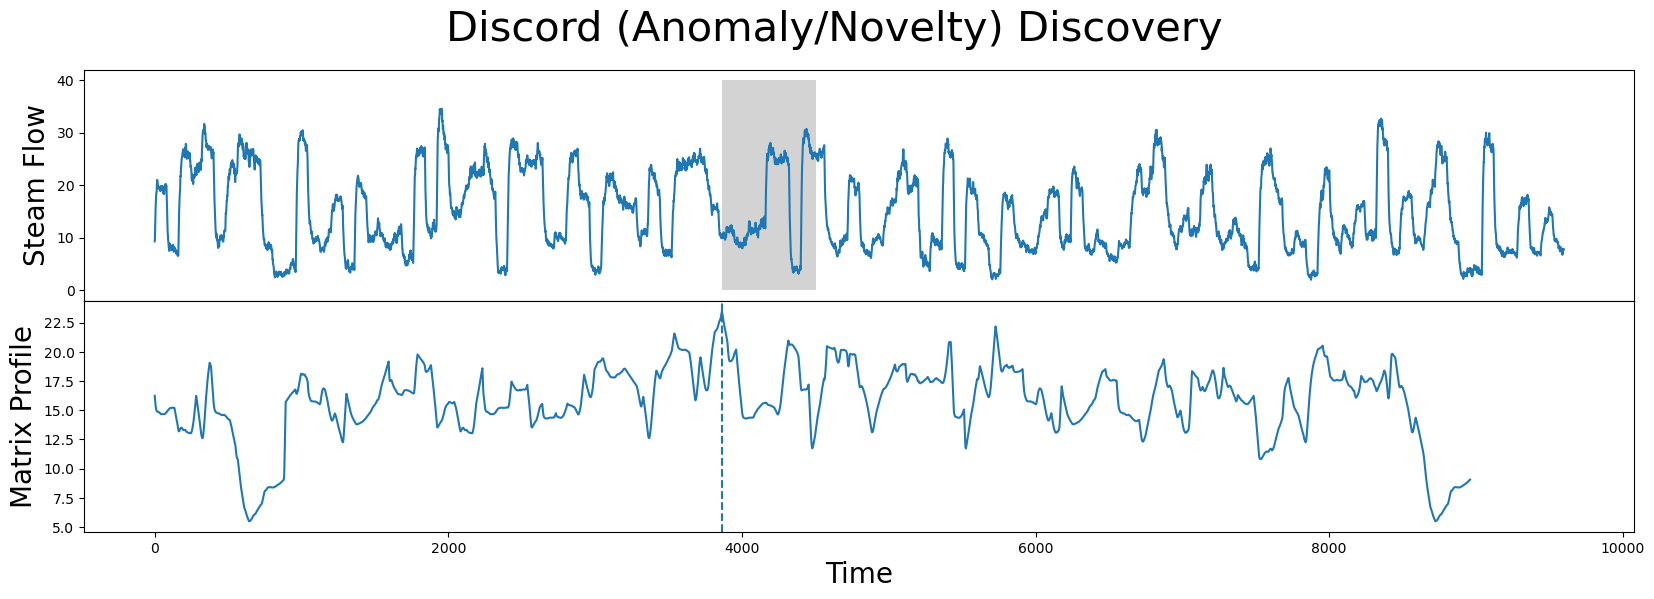

In [12]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
plt.suptitle('Discord (Anomaly/Novelty) Discovery', fontsize='30')

axs[0].plot(steam_df['steam flow'].values)
axs[0].set_ylabel('Steam Flow', fontsize='20')
rect = Rectangle((discord_idx, 0), m, 40, facecolor='lightgrey')
axs[0].add_patch(rect)
axs[1].set_xlabel('Time', fontsize ='20')
axs[1].set_ylabel('Matrix Profile', fontsize='20')
axs[1].axvline(x=discord_idx, linestyle="dashed")
axs[1].plot(mp[:, 0])
plt.show()

Now that you've mastered the STUMPY basics and understand how to discover motifs and anomalies from a time series, we'll leave it up to you to investigate other interesting local minima and local maxima in the steamgen dataset. 

To further develop/reinforce our growing intuition, let's move on and explore another dataset! 

## Loading the NYC Taxi Passengers Dataset

First, we'll download historical data that represents the half-hourly average of the number of NYC taxi passengers over 75 days in the Fall of 2014.


We extract that data and insert it into a pandas dataframe, making sure the timestamps are stored as *datetime* objects and the values are of type *float64*. Note that we'll do a little more data cleaning than above just so you can see an example where the timestamp is included. But be aware that `stump` does not actually use or need the timestamp column at all when computing the matrix profile.

In [13]:
taxi_df = pd.read_csv("https://zenodo.org/record/4276428/files/STUMPY_Basics_Taxi.csv?download=1")
taxi_df['value'] = taxi_df['value'].astype(np.float64)
taxi_df['timestamp'] = pd.to_datetime(taxi_df['timestamp'], errors='ignore')
taxi_df.head()

/var/folders/cc/95f7218n54l6mb7jmsyzvssr0000gn/T/ipykernel_84203/748043925.py:3: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  taxi_df['timestamp'] = pd.to_datetime(taxi_df['timestamp'], errors='ignore')
/var/folders/cc/95f7218n54l6mb7jmsyzvssr0000gn/T/ipykernel_84203/748043925.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  taxi_df['timestamp'] = pd.to_datetime(taxi_df['timestamp'], errors='ignore')


,timestamp,value
0,2014-10-01 00:00:00,12751.0
1,2014-10-01 00:30:00,8767.0
2,2014-10-01 01:00:00,7005.0
3,2014-10-01 01:30:00,5257.0
4,2014-10-01 02:00:00,4189.0


## Visualizing the Taxi Dataset

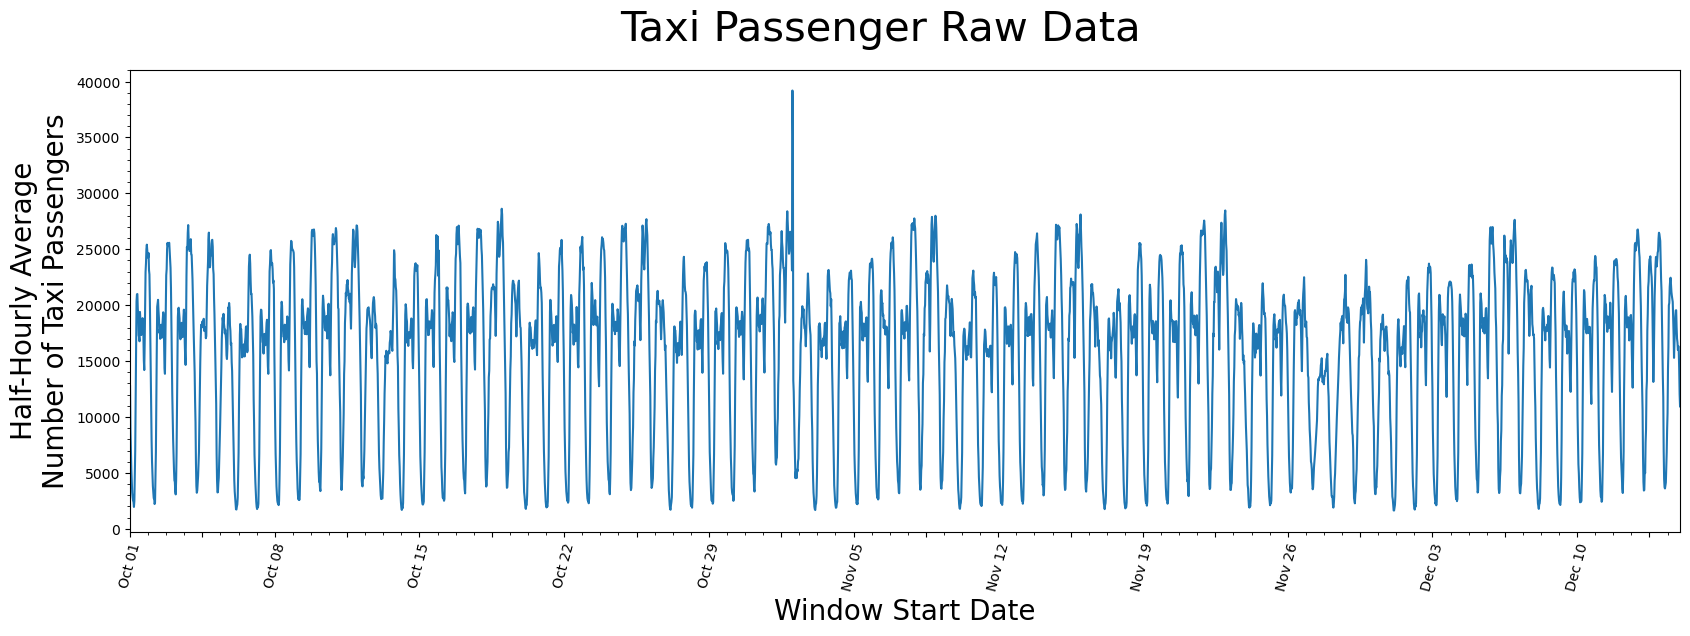

In [14]:
# This code is going to be utilized to control the axis labeling of the plots
DAY_MULTIPLIER = 7  # Specify for the amount of days you want between each labeled x-axis tick

x_axis_labels = taxi_df[(taxi_df.timestamp.dt.hour==0)]['timestamp'].dt.strftime('%b %d').values[::DAY_MULTIPLIER]
x_axis_labels[1::2] = " "
x_axis_labels, DAY_MULTIPLIER

plt.suptitle('Taxi Passenger Raw Data', fontsize='30')
plt.xlabel('Window Start Date', fontsize ='20')
plt.ylabel('Half-Hourly Average\nNumber of Taxi Passengers', fontsize='20')
plt.plot(taxi_df['value'])

plt.xticks(np.arange(0, taxi_df['value'].shape[0], (48*DAY_MULTIPLIER)/2), x_axis_labels)
plt.xticks(rotation=75)
plt.minorticks_on()
plt.margins(x=0)
plt.show()

It seems as if there is a general periodicity between spans of 1-day and 7-days, which can likely be explained by the fact that more people use taxis throughout the day than through the night and that it is reasonable to say most weeks have similar taxi-rider patterns. Also, maybe there is an outlier just to the right of the window starting near the end of October but, other than that, there isn't anything you can conclude from just looking at the raw data.

## Generating the Matrix Profile

Again, defining the window size, `m`, usually requires some level of domain knowledge but we'll demonstrate later on that `stump` is robust to changes in this parameter. Since this data was taken half-hourly, we chose a value `m = 48` to represent the span of exactly one day:

In [15]:
m = 48
mp = stumpy.stump(taxi_df['value'], m=m)

## Visualizing the Matrix Profile

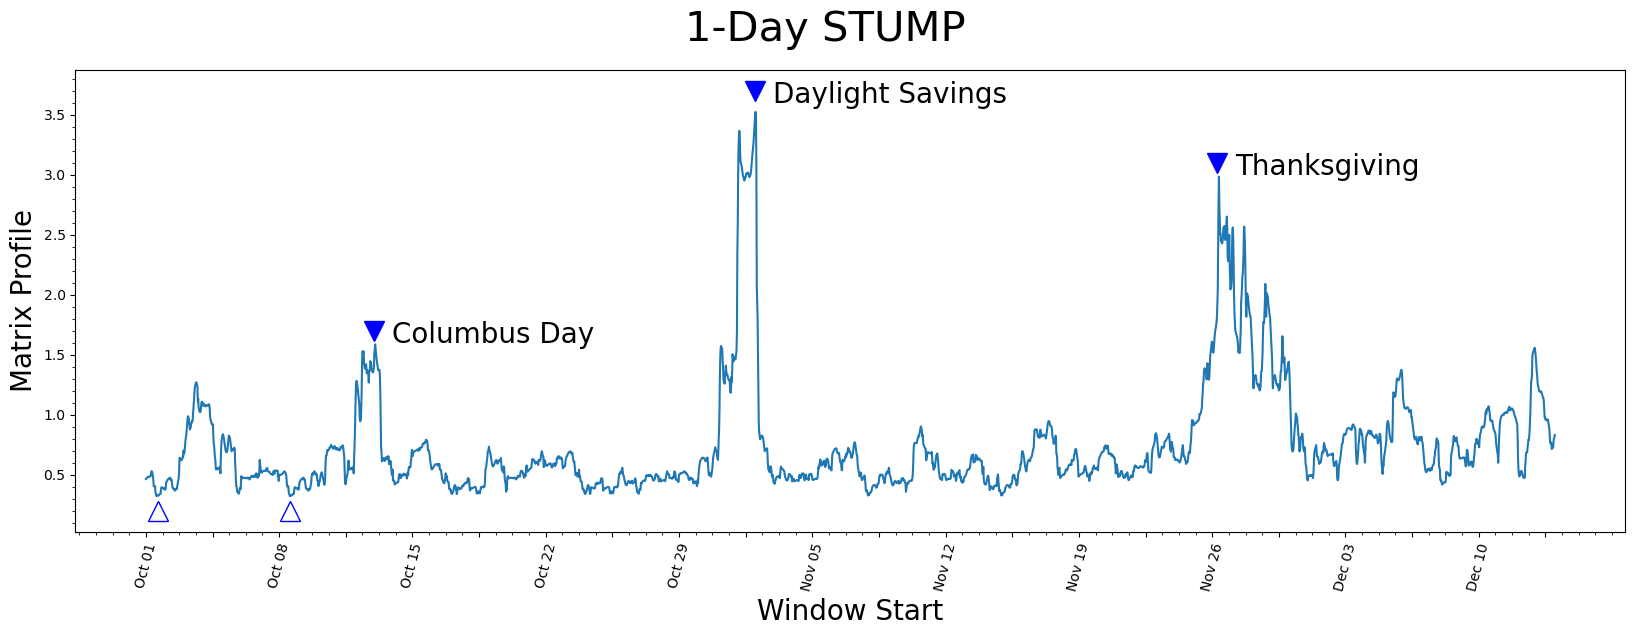

In [16]:
plt.suptitle('1-Day STUMP', fontsize='30')
plt.xlabel('Window Start', fontsize ='20')
plt.ylabel('Matrix Profile', fontsize='20')
plt.plot(mp[:, 0])

plt.plot(575, 1.7, marker="v", markersize=15, color='b')
plt.text(620, 1.6, 'Columbus Day', color="black", fontsize=20)
plt.plot(1535, 3.7, marker="v", markersize=15, color='b')
plt.text(1580, 3.6, 'Daylight Savings', color="black", fontsize=20)
plt.plot(2700, 3.1, marker="v", markersize=15, color='b')
plt.text(2745, 3.0, 'Thanksgiving', color="black", fontsize=20)
plt.plot(30, .2, marker="^", markersize=15, color='b', fillstyle='none')
plt.plot(363, .2, marker="^", markersize=15, color='b', fillstyle='none') 
plt.xticks(np.arange(0, 3553, (m*DAY_MULTIPLIER)/2), x_axis_labels)
plt.xticks(rotation=75)
plt.minorticks_on()
plt.show()

## Understanding the Matrix Profile

Let's understand what we're looking at.

### Lowest Values

The lowest values (open triangles) are considered a motif since they represent the pair of nearest neighbor subsequences with the smallest z-normalized Euclidean distance. Interestingly, the two lowest data points are *exactly* 7 days apart, which suggests that, in this dataset, there may be a periodicity of seven days in addition to the more obvious periodicity of one day.

### Highest Values

So what about the highest matrix profile values (filled triangles)? The subsequences that have the highest (local) values really emphasizes their uniqueness. We found that the top three peaks happened to correspond exactly with the timing of Columbus Day, Daylight Saving Time, and Thanksgiving, respectively.

## Different Window Sizes

As we had mentioned above, `stump` should be robust to the choice of the window size parameter, `m`. Below, we demonstrate how manipulating the window size can have little impact on your resulting matrix profile by running `stump` with varying windows sizes.

In [17]:
days_dict ={
  "Half-Day": 24,
  "1-Day": 48,
  "2-Days": 96,
  "5-Days": 240,
  "7-Days": 336,
}

days_df = pd.DataFrame.from_dict(days_dict, orient='index', columns=['m'])
days_df.head()

,m
Half-Day,24
1-Day,48
2-Days,96
5-Days,240
7-Days,336


We purposely chose spans of time that correspond to reasonably intuitive day-lengths that could be chosen by a human.

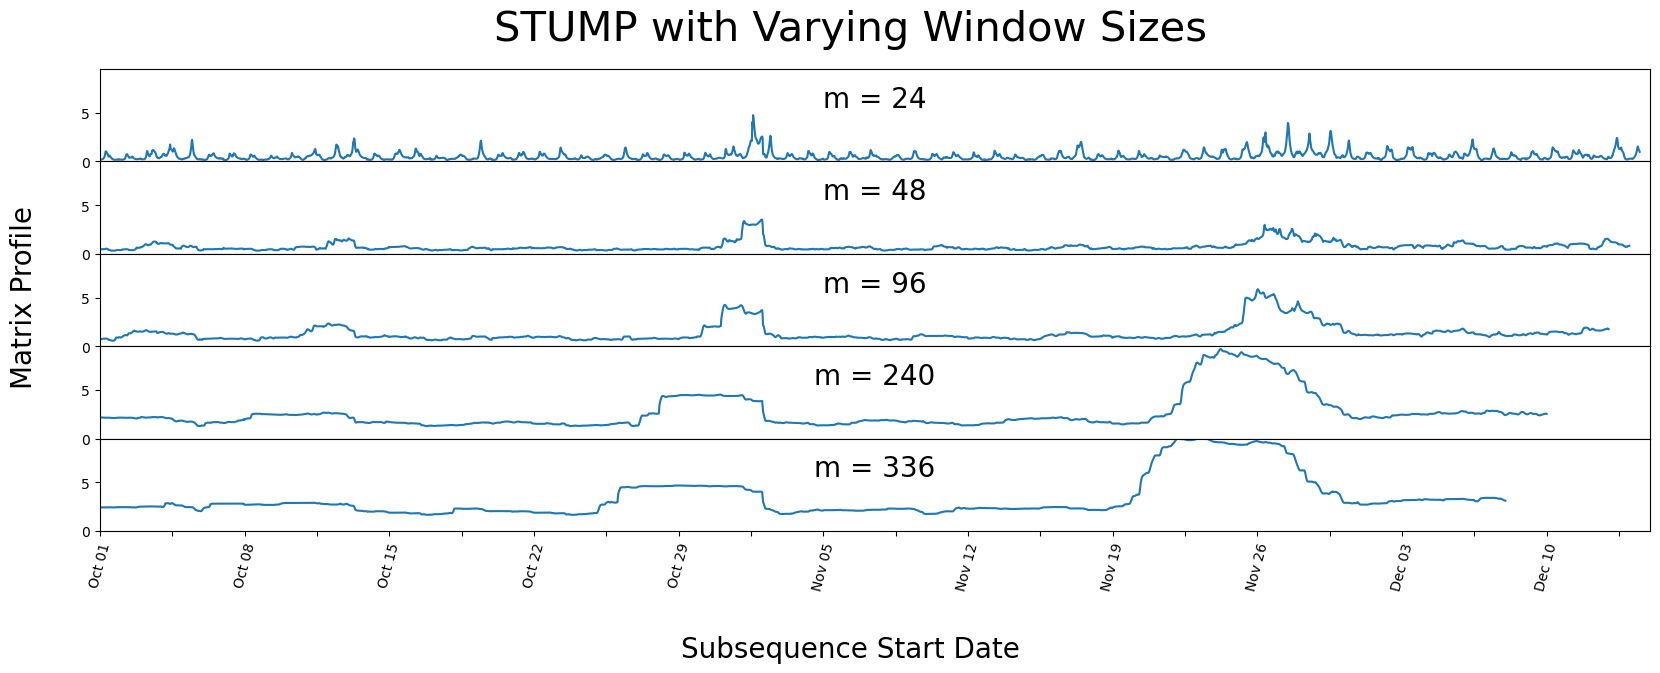

In [18]:
fig, axs = plt.subplots(5, sharex=True, gridspec_kw={'hspace': 0})
fig.text(0.5, -0.1, 'Subsequence Start Date', ha='center', fontsize='20')
fig.text(0.08, 0.5, 'Matrix Profile', va='center', rotation='vertical', fontsize='20')
for i, varying_m in enumerate(days_df['m'].values):
    mp = stumpy.stump(taxi_df['value'], varying_m)
    axs[i].plot(mp[:, 0])
    axs[i].set_ylim(0,9.5)
    axs[i].set_xlim(0,3600)
    title = f"m = {varying_m}"
    axs[i].set_title(title, fontsize=20, y=.5)
plt.xticks(np.arange(0, taxi_df.shape[0], (48*DAY_MULTIPLIER)/2), x_axis_labels)
plt.xticks(rotation=75)
plt.suptitle('STUMP with Varying Window Sizes', fontsize='30')
plt.show()

We can see that even with varying window sizes, our peaks stay prominent. But it looks as if all the non-peak values are converging towards each other. This is why having a knowledge of the data-context is important prior to running `stump`, as it is helpful to have a window size that may capture a repeating pattern or anomaly within the dataset.

## GPU-STUMP - Faster STUMP Using GPUs

When you have significantly more than a few thousand data points in your time series, you may need a speed boost to help analyze your data. Luckily, you can try `gpu_stump`, a super fast GPU-powered alternative to `stump` that gives speed of a few hundred CPUs and provides the same output as `stump`: 

```
import stumpy

mp = stumpy.gpu_stump(df['value'], m=m)  # Note that you'll need a properly configured NVIDIA GPU for this
```

In fact, if you aren't dealing with PII/SII data, then you can try out `gpu_stump` using the [this notebook on Google Colab](https://colab.research.google.com/drive/1FIbHQoD6mJInkhinoMehBDj2E1i7i2j7).

## STUMPED - Distributed STUMP

Alternatively, if you only have access to a cluster of CPUs and your data needs to stay behind your firewall, then `stump` and `gpu_stump` may not be sufficient for your needs. Instead, you can try `stumped`, a distributed and parallel implementation of `stump` that depends on [Dask distributed](https://distributed.dask.org/en/latest/):

```
import stumpy
from dask.distributed import Client

if __name__ == "__main__":
    with Client() as dask_client:
        mp = stumpy.stumped(dask_client, df['value'], m=m)  # Note that a dask client is needed
```

## Bonus Section

### Understanding the Matrix Profile Columnar Output

For any 1-D time series, `T`, its matrix profile, `mp`, computed from `stumpy.stump(T, m)` will contain 4 explicit columns, which we'll describe in a moment. Implicitly, the `i`th row of the `mp` array corresponds to the set of (4) nearest neighbor values computed for the specific subsequence `T[i : i + m]`.

The first column of the `mp` contains the matrix profile (nearest neighbor distance) value, `P` (note that due to zero-based indexing, the "first column" has a column index value of zero).
The second column contains the (zero-based) index location, `I`, of where the (above) nearest neighbor is located along `T` (note that any negative index values are "bad" values and indicates that a nearest neighbor could not be found).

So, for the `i`th subsequence `T[i : i + m]`, its nearest neighbor (located somewhere along `T`) has a starting index location of `I = mp[i, 1]` and, assuming that `I >= 0`, this corresponds to the subsequence found at `T[I : I + m]`. And the matrix profile value for the `i`th subsequence, `P = [i, 0]`, is the exact (z-normalized Euclidean) distance between `T[i : i + m]` and `T[I : I + m]`. Note that the nearest neighbor index location, `I`, can be positioned ANYWHERE. That is, dependent upon the `i`th subsequence, its nearest neighbor, `I`, can be located before/to-the-"left" of `i` (i.e., `I <= i`) or come after/to-the-"right" of `i` (i.e., `I >= i`). In other words, there is no constraint on where a nearest neighbor is located. However, there may be a time when you might like to only know about a nearest neighbor that either comes before/after `i` and this is where columns 3 and 4 of `mp` come into play.

The third column contains the (zero-based) index location, `IL`, of where the "left" nearest neighbor is located along `T`. Here, there is a constraint that `IL < i` or that `IL` must come before/to-the-left of `i`. Thus, the "left nearest neighbor" for the `i`th subsequence would be located at `IL = mp[i, 2]` and corresponds to `T[IL : IL + m]`.
The fourth column contains the (zero-based) index location, `IR`, of where the "right" nearest neighbor is located along `T`. Here, there is a constraint that `IR > i` or that `IR` must come after/to-the-right of `i`. Thus, the "right nearest neighbor" for the `i`th subsequence would be located at `IR = mp[i, 3]` and corresponds to `T[IR : IR + m]`.

Again, note that any negative index values are "bad" values and indicates that a nearest neighbor could not be found.

To reinforce this more concretely, let's use the following `mp` array as an example:

```
array([[1.626257115121311,  202, -1,  202],
       [1.7138456780667977,  65,  0,   65],
       [1.880293454724256,   66,  0,   66],
       [1.796922109741226,   67,  0,   67],
       [1.4943082939628236,  11,  1,   11],
       [1.4504278114808016,  12,  2,   12],
       [1.6294354134867932,  19,  0,   19],
       [1.5349365731102185, 229,  0,  229],
       [1.3930265554289831, 186,  1,  186],
       [1.5265881687159586, 187,  2,  187],
       [1.8022253384245739,  33,  3,   33],
       [1.4943082939628236,   4,  4,  118],
       [1.4504278114808016,   5,  5,  137],
       [1.680920620705546,  201,  6,  201],
       [1.5625058007723722, 237,  8,  237],
       [1.2860008417613522,  66,  9,   -1]]
```

Here, the subsequence at `i = 0` would correspond to the `T[0 : 0 + m]` subsequence and the nearest neighbor for this subsequence is located at `I = 202` (i.e., `mp[0, 1]`) and corresponds to the `T[202 : 202 + m]` subsequence. The z-normalized Euclidean distance between `T[0 : 0 + m]` and `T[202 : 202 + m]` is actually `P = 1.626257115121311` (i.e., `mp[0, 0]`). Next, notice that the location of the left nearest neighbor is `IL = -1` (i.e., `mp[0, 2]`) and, since negative indices are "bad", this tells us that the left nearest neighbor could not be found. Hopefully, this makes sense since `T[0 : 0 + m]` is the first subsequence in `T` and there are no other subsequences that can possibly exist to the left of `T[0 : 0 + m]`! Conversely, the location of the right nearest neighbor is `IR = 202` (i.e., `mp[0, 3]`) and corresponds to the `T[202 : 202 + m]` subsequence.

Additionally, the subsequence at `i = 5` would correspond to the `T[5 : 5 + m]` subsequence and the nearest neighbor for this subsequence is located at `I = 12` (i.e., `mp[5, 1]`) and corresponds to the `T[12 : 12 + m]` subsequence. The z-normalized Euclidean distance between `T[5 : 5 + m]` and `T[12 : 12 + m]` is actually `P = 1.4504278114808016` (i.e., `mp[5, 0]`). Next, the location of the left nearest neighbor is `IL = 2` (i.e., `mp[5, 2]`) and corresponds to `T[2 : 2 + m]`. Conversely, the location of the right nearest neighbor is `IR = 12` (i.e., `mp[5, 3]`) and corresponds to the `T[12 : 12 + m]` subsequence.

Similarly, all other subsequences can be evaluated and interpreted using this approach!

### Find Top-K Motifs

Now that you've computed the matrix profile, `mp`, for your time series and identified the best global motif, you may be interested in discovering other motifs within your data. However, you'll immediately learn that doing something like `top_10_motifs_idx = np.argsort(mp[:, 0])[10]` doesn't actually get you what you want and that's because this only returns the index locations that are likely going to be close to the global motif! Instead, after identifying the best motif (i.e., the matrix profile location with the smallest value), you first need to exclude the local area (i.e., an exclusion zone) surrounding the motif pair by setting their matrix profile values to `np.inf` before searching for the next motif. Then, you'll need to repeat the "exclude-and-search" process for each subsequent motif. Luckily, STUMPY offers two additional functions, namely, `stumpy.motifs` and `stumpy.match`, that help simplify this process. While it is beyond the scope of this basic tutorial, we encourage you to check them out!

## Summary

And that's it! You have now loaded in a dataset, ran it through `stump` using our package, and were able to extract multiple conclusions of existing patterns and anomalies within the two different time series. You can now import this package and use it in your own projects. Happy coding!

## Resources

[Matrix Profile I](http://www.cs.ucr.edu/~eamonn/PID4481997_extend_Matrix%20Profile_I.pdf)

[Matrix Profile II](http://www.cs.ucr.edu/~eamonn/STOMP_GPU_final_submission_camera_ready.pdf)

[STUMPY Documentation](https://stumpy.readthedocs.io/en/latest/)

[STUMPY Matrix Profile Github Code Repository](https://github.com/TDAmeritrade/stumpy)